In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import sys
import re
import json
import copy
import string
import random
import numpy as np
import pandas as pd

In [3]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
from nltk.tokenize import TweetTokenizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [4]:
!pip3 install textaugment
from textaugment import EDA

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.1 MB/s 
     |████████████████████████████████| 42 kB 1.3 MB/s 
     |████████████████████████████████| 1.4 MB 6.8 MB/s 
     |████████████████████████████████| 65 kB 3.7 MB/s 
     |████████████████████████████████| 53 kB 2.1 MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-py3-none-any.whl size=15735 sha256=f357079fad257494a88c3040b48a26c0da10b1764f5d255940128baa107f6dbc
  Stored in directory: /root/.cache/pip/wheels/20/da/eb/a54579056f265eede0417df537dd56d3df5b9eb2b25df0003d
Successfully built googletrans


In [5]:
!pip3 install symspellpy
from symspellpy.symspellpy import SymSpell, Verbosity
import pkg_resources

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.6 MB 4.1 MB/s 
     |████████████████████████████████| 125 kB 64.2 MB/s 


In [6]:
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models.keyedvectors import KeyedVectors

In [7]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.utils import class_weight, shuffle
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
import tensorflow as tf
import tensorflow_hub as hub
print(tf.__version__)

from keras import backend as K
from tensorflow.keras import Sequential, Model, initializers, regularizers, constraints
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Bidirectional, LeakyReLU, Dropout, Masking, TimeDistributed, SimpleRNN, Conv1D, GlobalMaxPooling1D, Concatenate, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


2.9.2


In [9]:
!pip3 install transformers
from transformers import BertTokenizer, TFBertForSequenceClassification

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 4.0 MB/s 
     |████████████████████████████████| 163 kB 47.4 MB/s 
     |████████████████████████████████| 7.6 MB 37.4 MB/s 


In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
random_root = 60

### **Import dataset**

In [12]:
comments_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CS5344/sentimental_analysis.csv')

In [13]:
# Take a glance on the dataset
comments_data.head(5)

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


In [14]:
with open('/content/drive/MyDrive/Colab Notebooks/CS5344/english_contractions.json', 'r') as f:
    eng_contractions = json.load(f)

In [15]:
comments = comments_data[['content', 'sentiment']]
comments_df = comments.rename(columns={'content':'sentence', 'sentiment':'label'})
comments_df['sentence'] = comments_df['sentence'].apply(str.lower)
print(len(comments_df))
comments_df.head(5)

40000


,sentence,label
0,@tiffanylue i know i was listenin to bad habi...,empty
1,layin n bed with a headache ughhhh...waitin o...,sadness
2,funeral ceremony...gloomy friday...,sadness
3,wants to hang out with friends soon!,enthusiasm
4,@dannycastillo we want to trade with someone w...,neutral


### **Select the sentiment types and deal with labels**

In [16]:
def merge_classes(label):
    label_map = {'love': 'happiness', 'enthusiasm': 'fun', 'worry': 'sadness', 'anger': 'hate'}
    if label in label_map:
        return label_map[label]
    else:
        return label

In [17]:
comments_df['label'] = comments_df['label'].map(lambda l: merge_classes(l))

In [18]:
all_classes = sorted(comments_df['label'].unique().tolist())
for cls in all_classes:
    cls_cnt = len(comments_df[comments_df['label'] == cls])
    print(f"{cls}: {cls_cnt}")

boredom: 179
empty: 827
fun: 2535
happiness: 9051
hate: 1433
neutral: 8638
relief: 1526
sadness: 13624
surprise: 2187


In [19]:
# 删除neutral类，用后续得到的各个class的score来判断是否neutral
classes = ['happiness', 'fun', 'sadness', 'hate']
num_classes = len(classes)
ori_comments_df = comments_df[comments_df['label'].isin(classes)]
print(len(ori_comments_df))
ori_comments_df.head(5)

26643


,sentence,label
1,layin n bed with a headache ughhhh...waitin o...,sadness
2,funeral ceremony...gloomy friday...,sadness
3,wants to hang out with friends soon!,fun
5,re-pinging @ghostridah14: why didn't you go to...,sadness
6,"i should be sleep, but im not! thinking about ...",sadness


In [20]:
class_idx_dict = {}
for i, c in enumerate(classes):
    class_idx_dict[c] = i
print(class_idx_dict)

{'happiness': 0, 'fun': 1, 'sadness': 2, 'hate': 3}


In [21]:
# all_sample_classes = np.asarray(ori_comments_df['label'].values.tolist())
# class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=all_sample_classes)
# class_weight_dict = dict(enumerate(class_weights))
# class_weight_dict

In [22]:
cat_to_one_hot_dict = {}
for cls, i in class_idx_dict.items():
    one_hot_arr = np.zeros(shape=(num_classes,), dtype='int32')
    one_hot_arr[i] = 1
    cat_to_one_hot_dict[cls] = one_hot_arr
cat_to_one_hot_dict

{'happiness': array([1, 0, 0, 0], dtype=int32),
 'fun': array([0, 1, 0, 0], dtype=int32),
 'sadness': array([0, 0, 1, 0], dtype=int32),
 'hate': array([0, 0, 0, 1], dtype=int32)}

In [23]:
# ori_comments_df['label_arr'] = ori_comments_df['label'].apply(lambda cls: cat_to_one_hot_dict[cls])
# ori_comments_df

### **Preprocessing texts**

In [24]:
def normalize_contractions(sentence, eng_contractions_dict):
    return _normalize_contractions_text(sentence, eng_contractions_dict)

def _normalize_contractions_text(text, contractions):
    """
    This function normalizes english contractions (all input sentences in lower case).
    """
    new_token_list = []
    token_list = text.split()
    for word_pos in range(len(token_list)):
        word = token_list[word_pos]
        if word in contractions:
            replacement = contractions[word]

            first_rep = replacement.strip().split('/')[0]
            replacement_tokens = first_rep.strip().split()
            for w in replacement_tokens:
                new_token_list.append(w)
        else:
            new_token_list.append(word)
    sentence = " ".join(new_token_list).strip(" ")
    return sentence

In [25]:
def simplify_punctuation_and_whitespace(sentence):

    # print("Normalizing whitespaces and punctuation")
    sent = _replace_urls(sentence)
    sent = _simplify_punctuation(sent)
    simplified_sent = _normalize_whitespace(sent)
      
    return simplified_sent

def _replace_urls(text):
    url_regex = r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
    text = re.sub(url_regex, "<URL>", text)
    return text

def _simplify_punctuation(text):
    """
    This function simplifies doubled or more complex punctuation. The exception is '...'.
    """
    corrected = str(text)
    corrected = re.sub(r'([!?,;])\1+', r'\1', corrected)
    corrected = re.sub(r'\.{2,}', r'...', corrected)
    return corrected

def _normalize_whitespace(text):
    """
    This function normalizes whitespaces, removing duplicates.
    """
    corrected = str(text)
    corrected = re.sub(r"//t",r"\t", corrected)
    corrected = re.sub(r"( )\1+",r"\1", corrected)
    corrected = re.sub(r"(\n)\1+",r"\1", corrected)
    corrected = re.sub(r"(\r)\1+",r"\1", corrected)
    corrected = re.sub(r"(\t)\1+",r"\1", corrected)
    return corrected.strip(" ")

def reduce_exaggerations(text):
    """
    Auxiliary function to help with exxagerated words.
    Examples:
        woooooords -> words
        yaaaaaaaaaaaaaaay -> yay
    """
    correction = str(text)
    #TODO work on complexity reduction.
    return re.sub(r'(.)\1+', r'\1\1', correction)

In [26]:
# def load_spellchecker():
#     max_edit_distance_dictionary= 3
#     prefix_length = 4
#     spellchecker = SymSpell(max_edit_distance_dictionary, prefix_length)
#     dictionary_path = pkg_resources.resource_filename(
#         "symspellpy", "frequency_dictionary_en_82_765.txt")
#     bigram_path = pkg_resources.resource_filename(
#         "symspellpy", "frequency_bigramdictionary_en_243_342.txt")
#     spellchecker.load_dictionary(dictionary_path, term_index=0, count_index=1)
#     spellchecker.load_bigram_dictionary(dictionary_path, term_index=0, count_index=2)

#     return spellchecker

# def spell_correction(sentence, spellchecker):

#     print("Spell correcting")
#     norm_sentence = _spell_correction_text(sentence, spellchecker)
#     return norm_sentence

# def _spell_correction_text(text, spellchecker):
#     """
#     This function does very simple spell correction normalization using pyspellchecker module. It works over a tokenized sentence and only the token representations are changed.
#     """
#     if len(text) < 1:
#         return ""
#     #Spell checker config
#     max_edit_distance_lookup = 2
#     suggestion_verbosity = Verbosity.TOP # TOP, CLOSEST, ALL
#     #End of Spell checker config
#     token_list = text.strip().split()
#     for word_pos in range(len(token_list)):
#         word = token_list[word_pos]
#         if word is None:
#             token_list[word_pos] = ""
#             continue
#         if not '\n' in word and word not in string.punctuation and not is_numeric(word) and not (word in spellchecker.words.keys()):
#             suggestions = spellchecker.lookup(word, suggestion_verbosity, max_edit_distance_lookup)

#             #Checks for correction suggestions.
#             if len(suggestions) > 0:
#                 correction = suggestions[0].term
#                 replacement = correction
#             #We call our _reduce_exaggerations function if no suggestion is found. Maybe there are repeated chars.
#             else:
#                 replacement = _reduce_exaggerations(word)
#             word = replacement
#             token_list[word_pos] = word
#     return " ".join(token_list)

# def _reduce_exaggerations(text):
#     """
#     Auxiliary function to help with exxagerated words.
#     Examples:
#         woooooords -> words
#         yaaaaaaaaaaaaaaay -> yay
#     """
#     correction = str(text)
#     #TODO work on complexity reduction.
#     return re.sub(r'([\w])\1+', r'\1', correction)

# def is_numeric(text):
#     for char in text:
#         if not (char in "0123456789" or char in ",%.$"):
#             return False
#     return True

In [27]:
# spell_chekcer = load_spellchecker()

ori_comments_df['sentence'] = ori_comments_df['sentence'].map(lambda x: normalize_contractions(x, eng_contractions))
ori_comments_df['sentence'] = ori_comments_df['sentence'].map(lambda x: simplify_punctuation_and_whitespace(x))
ori_comments_df['sentence'] = ori_comments_df['sentence'].map(lambda x: reduce_exaggerations(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [28]:
ori_comments_df.head(5)

,sentence,label
1,layin n bed with a headache ughh..waitin on yo...,sadness
2,funeral ceremony..gloomy friday..,sadness
3,wants to hang out with friends soon!,fun
5,re-pinging @ghostridah14: why did not you go t...,sadness
6,"i should be sleep, but im not! thinking about ...",sadness


### **EDA sentence angmentation**

In [29]:
eda_tool = EDA(random_state=random_root)

In [30]:
cnt_class_dict = {}
max_cnt = 0
for cls in classes:
    cls_cnt = len(ori_comments_df[ori_comments_df['label'] == cls])
    cnt_class_dict[cls] = cls_cnt
    max_cnt = max(max_cnt, cls_cnt)
    print(f"{cls}: {cls_cnt}")

happiness: 9051
fun: 2535
sadness: 13624
hate: 1433


In [31]:
def eda_augmentation(ori_comments_df, cls, max_cnt, cnt_class_dict):
    ori_df = ori_comments_df[ori_comments_df['label'] == cls]
    ori_sentences = ori_df['sentence'].values.tolist()
    m = len(ori_sentences)
    rep_target = max_cnt - cnt_class_dict[cls]
    num_words_to_rep_list = random.choices([1,2,3], weights=[2, 3, 1], k=rep_target)

    labels = [cls] * rep_target
    new_sentences = [''] * rep_target

    i = 0
    while i < rep_target:
        # num_words_to_rep = random.randint(1,2)
        new_sentence = eda_tool.synonym_replacement(ori_sentences[i % m], num_words_to_rep_list[i])
        new_sentences[i] = new_sentence
        i += 1
    aug_df = pd.DataFrame({'sentence': new_sentences,
                           'label': labels
                           })

    return aug_df

In [32]:
augmented_df = copy.deepcopy(ori_comments_df)
for cls in classes:
    cls_aug_df = eda_augmentation(ori_comments_df, cls, max_cnt, cnt_class_dict)
    augmented_df = pd.concat([augmented_df, cls_aug_df])
augmented_df.reset_index(drop=True, inplace=True)

In [33]:
augmented_df

,sentence,label
0,layin n bed with a headache ughh..waitin on yo...,sadness
1,funeral ceremony..gloomy friday..,sadness
2,wants to hang out with friends soon!,fun
3,re-pinging @ghostridah14: why did not you go t...,sadness
4,"i should be sleep, but im not! thinking about ...",sadness
...,...,...
54491,the only thing about devise 5 sermons in one w...,hate
54492,"not making good time, fucking windy city traff...",hate
54493,why does twitter detest me i cant put no photo...,hate
54494,well off the clock twitter friends. sidenote: ...,hate


In [34]:
for cls in classes:
    cls_cnt = len(augmented_df[augmented_df['label'] == cls])
    print(f"{cls}: {cls_cnt}")

happiness: 13624
fun: 13624
sadness: 13624
hate: 13624


In [35]:
augmented_df['label_arr'] = augmented_df['label'].apply(lambda cls: cat_to_one_hot_dict[cls])
augmented_df

,sentence,label,label_arr
0,layin n bed with a headache ughh..waitin on yo...,sadness,"[0, 0, 1, 0]"
1,funeral ceremony..gloomy friday..,sadness,"[0, 0, 1, 0]"
2,wants to hang out with friends soon!,fun,"[0, 1, 0, 0]"
3,re-pinging @ghostridah14: why did not you go t...,sadness,"[0, 0, 1, 0]"
4,"i should be sleep, but im not! thinking about ...",sadness,"[0, 0, 1, 0]"
...,...,...,...
54491,the only thing about devise 5 sermons in one w...,hate,"[0, 0, 0, 1]"
54492,"not making good time, fucking windy city traff...",hate,"[0, 0, 0, 1]"
54493,why does twitter detest me i cant put no photo...,hate,"[0, 0, 0, 1]"
54494,well off the clock twitter friends. sidenote: ...,hate,"[0, 0, 0, 1]"


### **Load pre-trained wordvectors**

In [36]:
big_corpus_model = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Colab Notebooks/CS5344/glove.twitter.27B.50d.txt', binary=False)

In [43]:
big_corpus_model.wv.most_similar('he', topn=5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


[('has', 0.9026907086372375),
 ('was', 0.8521920442581177),
 ('once', 0.8304729461669922),
 ('had', 0.8299785852432251),
 ('she', 0.8254218101501465)]

In [58]:
big_corpus_word_vectors_dict = big_corpus_model.wv

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [51]:
big_corpus_word_vectors_dict['home']

array([-0.043148,  0.50393 ,  0.27095 , -0.1198  , -0.58991 , -0.32774 ,
        0.15549 , -0.5465  ,  0.4169  ,  1.5267  , -0.48707 , -0.095806,
       -5.9675  ,  0.12915 , -0.48301 , -0.14715 ,  0.12052 , -0.19595 ,
       -0.86387 , -0.17507 ,  0.4924  ,  0.38274 ,  0.2987  ,  0.13115 ,
       -0.13744 , -0.20918 ,  0.10783 , -0.10709 ,  0.41345 ,  0.11004 ,
       -0.44554 ,  0.2905  , -0.14988 ,  0.29897 , -0.050136,  0.46923 ,
        0.15687 , -0.04682 , -0.11082 ,  0.87676 , -1.6183  ,  0.59109 ,
        0.097853,  0.32855 , -0.2794  ,  0.074711,  1.0258  , -0.22383 ,
       -0.66025 , -0.70649 ], dtype=float32)

In [52]:
def sentence_tokenizer(tk, sentence, big_corpus):
    words_list = tk.tokenize(sentence)
    tokenized_words_list = []
    i = 0

    while i < len(words_list):
        if words_list[i].startswith('http') or words_list[i].startswith('www.'):
            i += 1
        elif words_list[i].endswith('.com'):
            i += 1
        # elif words_list[i-1] in string.punctuation and words_list[i] in string.punctuation:
        #     i += 1
        elif words_list[i] in string.punctuation:
            i += 1
        elif (len(words_list[i]) > 1) and (not (ord('a') <= ord(words_list[i][0]) <= ord('z'))) and (not words_list[i].startswith('<')):
            i += 1
        elif words_list[i].startswith('@'):
            tokenized_words_list.append('<person>')
            i += 1
        else:
            tokenized_words_list.append(words_list[i])
            i += 1

    for j, w in enumerate(tokenized_words_list):
        if w not in big_corpus:
            tokenized_words_list[j] = 'unk'

    return tokenized_words_list

In [53]:
ori_comments_df = augmented_df

In [54]:
tk = TweetTokenizer()
ori_comments_df['tokens'] = ori_comments_df['sentence'].map(lambda x: sentence_tokenizer(tk, x, big_corpus_word_vectors_dict))

In [ ]:
t = Tokenizer()
t.fit_on_texts(ori_comments_df['tokens'])
vocab_size = len(t.word_index) + 1
vocab_to_int_dict = t.word_index

In [ ]:
print(len(vocab_to_int_dict))
print(vocab_to_int_dict)

22598
{'i': 1, 'to': 2, 'unk': 3, 'the': 4, 'a': 5, 'my': 6, 'it': 7, 'and': 8, 'you': 9, 'is': 10, 'not': 11, 'in': 12, 'for': 13, 'of': 14, 'have': 15, 'am': 16, 'that': 17, 'me': 18, 'on': 19, 'so': 20, 'has': 21, 'but': 22, 'just': 23, 'do': 24, 'with': 25, 'be': 26, 'at': 27, 'are': 28, 'day': 29, 'was': 30, 'this': 31, 'up': 32, 'out': 33, 'all': 34, 'now': 35, 'good': 36, 'get': 37, 'going': 38, 'like': 39, 'lol': 40, 'go': 41, 'no': 42, 'work': 43, 'too': 44, 'your': 45, 'got': 46, 'we': 47, 'will': 48, 'love': 49, 'today': 50, 'had': 51, 'from': 52, 'what': 53, 'want': 54, 'cannot': 55, 'there': 56, 'u': 57, 'its': 58, 'really': 59, 'im': 60, 'one': 61, 'time': 62, 'some': 63, 'when': 64, 'about': 65, 'off': 66, 'back': 67, 'they': 68, 'know': 69, 'hate': 70, 'can': 71, 'happy': 72, 'see': 73, 'did': 74, 'if': 75, 'as': 76, 'night': 77, 'haha': 78, 'how': 79, 'an': 80, 'here': 81, 'new': 82, 'much': 83, 'well': 84, 'fun': 85, 'think': 86, 'more': 87, 'shall': 88, 'thanks': 89,

In [ ]:
# Save the "vocab_to_int_dict" as a json file
with open('/content/drive/MyDrive/Colab Notebooks/CS5344/vocab_to_idx_1.json', 'w') as f:
    s = json.dumps(vocab_to_int_dict)
    f.write(s)

In [ ]:
ori_comments_df.head(5)

,sentence,label,label_arr,tokens
1,layin n bed with a headache ughh..waitin on yo...,sadness,"[0, 0, 1, 0]","[layin, n, bed, with, a, headache, ughh, waiti..."
2,funeral ceremony..gloomy friday..,sadness,"[0, 0, 1, 0]","[funeral, ceremony, gloomy, friday]"
3,wants to hang out with friends soon!,fun,"[0, 1, 0, 0]","[wants, to, hang, out, with, friends, soon]"
5,re-pinging @ghostridah14: why did not you go t...,sadness,"[0, 0, 1, 0]","[unk, why, did, not, you, go, to, prom, bc, my..."
6,"i should be sleep, but im not! thinking about ...",sadness,"[0, 0, 1, 0]","[i, should, be, sleep, but, im, not, thinking,..."


In [ ]:
embedding_matrix = np.zeros((vocab_size, 50))
count = 0

for word, i in vocab_to_int_dict.items():
    try:
        embedding_vector = big_corpus_word_vectors_dict[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        count += 1
        
print(f"Number of words that are not in the vocab: {count}")

Number of words that are not in the vocab: 0


In [ ]:
big_corpus_model.wv.most_similar('what', topn=5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


[('that', 0.9665623903274536),
 ('how', 0.9635433554649353),
 ('know', 0.9635046720504761),
 ('why', 0.9620631337165833),
 ('it', 0.9601348638534546)]

### **DEPRECATED: Train Word2Vec to get vectors for infrequently seen words**

In [ ]:
def sentence_tokenizer(tk, sentence):
    words_list = tk.tokenize(sentence)
    tokenized_words_list = []
    i = 0

    while i < len(words_list):
        if words_list[i].startswith('http') or words_list[i].startswith('www.'):
            i += 1
        elif words_list[i].endswith('.com'):
            i += 1
        elif words_list[i].startswith('@'):
            tokenized_words_list.append('<person>')
            i += 1
        elif words_list[i-1] in string.punctuation and words_list[i] in string.punctuation:
            i += 1
        elif (len(words_list[i]) > 1) and (not (ord('a') <= ord(words_list[i][0]) <= ord('z'))) and (not words_list[i].startswith('<')):
            i += 1
        else:
            tokenized_words_list.append(words_list[i])
            i += 1

    return tokenized_words_list

In [ ]:
tk = TweetTokenizer()
ori_comments_df['tokens'] = ori_comments_df['sentence'].map(lambda x: sentence_tokenizer(tk, x))

In [ ]:
ori_comments_df.head(5)

In [ ]:
my_model = Word2Vec(
    sentences = ori_comments_df['tokens'],
    size = 50,
    window = 4,
    min_count=2
)
# model.save('word2vec.model')

In [ ]:
my_model.wv.most_similar('fun', topn=5)

In [ ]:
my_model_vectors_dict = my_model.wv

In [ ]:
t = Tokenizer()
t.fit_on_texts(ori_comments_df['tokens'])
vocab_size = len(t.word_index) + 1
vocab_to_int_dict = t.word_index

In [ ]:
embedding_matrix = np.zeros((vocab_size, 50))
count = 0

for word, i in vocab_to_int_dict.items():
    try:
        embedding_vector = my_model_vectors_dict[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        count += 1
        
print(f"Number of words that are not in the vocab: {count}")

In [ ]:
comments_df = ori_comments_df[ori_comments_df['tokens'].map(lambda x: len(x) > 8)]

In [ ]:
comments_df.head(10)

In [ ]:
# drop_columns = ['label', 'sentence']
# for c in drop_columns:
#   if c in comments_df.columns:
#       comments_df.drop(columns=[c], axis=1, inplace=True)
# comments_df.head(5)

In [ ]:
ori_comments_df.head(10)

### **Get datasets ready**

In [ ]:
# df = copy.deepcopy(ori_comments_df)
df = ori_comments_df[ori_comments_df['tokens'].map(lambda x: len(x) > 8)]

In [ ]:
df['tokens_ids'] = df['tokens'].apply(lambda x: [vocab_to_int_dict.get(w, 0) for w in x])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df.head(5)

,sentence,label,label_arr,tokens,tokens_ids
1,layin n bed with a headache ughh..waitin on yo...,sadness,"[0, 0, 1, 0]","[layin, n, bed, with, a, headache, ughh, waiti...","[11774, 264, 155, 25, 5, 425, 778, 1667, 19, 4..."
5,re-pinging @ghostridah14: why did not you go t...,sadness,"[0, 0, 1, 0]","[unk, why, did, not, you, go, to, prom, bc, my...","[3, 98, 74, 11, 9, 41, 2, 848, 1636, 6, 1668, ..."
6,"i should be sleep, but im not! thinking about ...",sadness,"[0, 0, 1, 0]","[i, should, be, sleep, but, im, not, thinking,...","[1, 113, 26, 130, 22, 60, 11, 395, 65, 80, 240..."
12,ugh! i have to beat this stupid song to get to...,sadness,"[0, 0, 1, 0]","[ugh, i, have, to, beat, this, stupid, song, t...","[175, 1, 15, 2, 992, 31, 207, 294, 2, 37, 2, 4..."
13,@brodyjenner if u watch the hills in london u ...,sadness,"[0, 0, 1, 0]","[if, u, watch, the, hills, in, london, u, will...","[75, 57, 195, 4, 3671, 12, 734, 57, 48, 1536, ..."


In [ ]:
seqLen = 15
padded_sentence = pad_sequences(df['tokens_ids'], maxlen=seqLen, padding='post')
df['tokens_ids'] = [list(doc) for doc in padded_sentence]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df.head(5)

,sentence,label,label_arr,tokens,tokens_ids
1,layin n bed with a headache ughh..waitin on yo...,sadness,"[0, 0, 1, 0]","[layin, n, bed, with, a, headache, ughh, waiti...","[11774, 264, 155, 25, 5, 425, 778, 1667, 19, 4..."
5,re-pinging @ghostridah14: why did not you go t...,sadness,"[0, 0, 1, 0]","[unk, why, did, not, you, go, to, prom, bc, my...","[98, 74, 11, 9, 41, 2, 848, 1636, 6, 1668, 74,..."
6,"i should be sleep, but im not! thinking about ...",sadness,"[0, 0, 1, 0]","[i, should, be, sleep, but, im, not, thinking,...","[247, 149, 1, 54, 22, 90, 21, 1509, 35, 158, 9..."
12,ugh! i have to beat this stupid song to get to...,sadness,"[0, 0, 1, 0]","[ugh, i, have, to, beat, this, stupid, song, t...","[175, 1, 15, 2, 992, 31, 207, 294, 2, 37, 2, 4..."
13,@brodyjenner if u watch the hills in london u ...,sadness,"[0, 0, 1, 0]","[if, u, watch, the, hills, in, london, u, will...","[1536, 53, 3, 7, 10, 159, 146, 480, 8, 480, 34..."


In [ ]:
np.asarray(df['label_arr'].values.tolist()).shape

(39763, 4)

### **Get balanced train data set**

In [ ]:
# eda_tool = EDA(random_state=random_root)

In [ ]:
# eda_tool.synonym_replacement("i used to be a good man, but things happen.", 2)

'i used to be a just man, but thing happen.'

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.05, random_state=random_root, shuffle=True, stratify=df['label'])

In [ ]:
max_cnt = 0
for cls in classes:
    cls_cnt = len(df_train[df_train['label'] == cls])
    max_cnt = max(max_cnt, cls_cnt)
    print(f"{cls}: {cls_cnt}")

happiness: 9008
fun: 9669
sadness: 9433
hate: 9664


In [ ]:
df_train.head(5)

,sentence,label,label_arr,tokens,tokens_ids
5368,and i want you to shut the have sex up.. i rea...,hate,"[0, 0, 0, 1]","[and, i, want, you, to, shut, the, have, sex, ...","[32, 1, 59, 70, 851, 25, 6, 1819, 451, 1, 55, ..."
13130,damn just spent a week whole of pay on shoppin...,happiness,"[1, 0, 0, 0]","[damn, just, spent, a, week, whole, of, pay, o...","[158, 23, 787, 5, 127, 397, 14, 721, 19, 487, ..."
10768,@19fischi75 dont conceive me ugly - but tha du...,hate,"[0, 0, 0, 1]","[dont, conceive, me, ugly, but, tha, dumb, ass...","[18, 993, 22, 1071, 1403, 352, 10, 1311, 5, 56..."
4371,@aboveallfabric wow! you have been twinge all ...,fun,"[0, 1, 0, 0]","[wow, you, have, been, twinge, all, night, loo...","[9, 15, 101, 2400, 34, 77, 242, 39, 9, 2624, 2..."
5763,on jacksonville beach walk in the cold ass wat...,hate,"[0, 0, 0, 1]","[on, jacksonville, beach, walk, in, the, cold,...","[797, 12, 4, 320, 352, 509, 22, 15, 2, 4159, 1..."


In [ ]:
# df_mul_train = pd.DataFrame()
# for c in classes:
#     class_df = df_train[df_train['label'] == c]
#     mul = max_cnt // len(class_df)
#     print(mul)
#     df_mul_class = [class_df]*mul
#     df_mul_class.append(df_mul_train)
    
#     df_mul_train = pd.concat(df_mul_class, ignore_index=True)

In [ ]:
df_mul_train = df_train

In [ ]:
# max_cnt = 0
# for cls in classes:
#     cls_cnt = len(df_mul_train[df_mul_train['label'] == cls])
#     max_cnt = max(max_cnt, cls_cnt)
#     print(f"{cls}: {cls_cnt}")

# print(max_cnt)

happiness: 9008
fun: 9669
sadness: 9433
hate: 9664


In [ ]:
print(len(df_train))
print(len(df_mul_train))

37774
37774


In [ ]:
df_mul_train = shuffle(df_mul_train, random_state=random_root)
df_mul_train.reset_index(drop=True, inplace=True)
df_mul_train.head(10)

,sentence,label,label_arr,tokens,tokens_ids
0,@dnbchik ahh..lily's new kitten just took a gi...,hate,"[0, 0, 0, 1]","[ahh, unk, new, kitten, just, took, a, giant, ...","[303, 3, 82, 2371, 23, 447, 5, 1603, 1498, 131..."
1,"ok, rachis to packing. have been sitting in ca...",happiness,"[1, 0, 0, 0]","[ok, unk, to, packing, have, been, sitting, in...","[795, 15, 101, 524, 12, 232, 10989, 206, 76, 2..."
2,@tedmurphy thank for the follow. i am loving t...,happiness,"[1, 0, 0, 0]","[thank, for, the, follow, i, am, loving, the, ...","[19, 45, 579, 4, 13488, 12, 18, 55, 367, 22, 2..."
3,ugg want to go to kaylen house but i cant fixi...,sadness,"[0, 0, 1, 0]","[ugg, want, to, go, to, kaylen, house, but, i,...","[31, 125, 3, 54, 2, 688, 982, 738, 8, 41, 73, ..."
4,@magnum74 i knew my mom loved flowers and she ...,happiness,"[1, 0, 0, 0]","[i, knew, my, mom, loved, flowers, and, she, l...","[6, 227, 475, 1660, 8, 97, 638, 4, 21043, 2104..."
5,going to bed watching a bit of qi. wake up tom...,sadness,"[0, 0, 1, 0]","[going, to, bed, watching, a, bit, of, qi, wak...","[452, 4, 260, 14, 6, 105, 307, 12, 2460, 291, ..."
6,@joy_b i do not know but they are not worth it...,fun,"[0, 1, 0, 0]","[i, do, not, know, but, they, are, not, worth,...","[11, 69, 22, 68, 28, 11, 694, 7, 106, 3, 133, ..."
7,just got woken up by my mom.. our entire first...,hate,"[0, 0, 0, 1]","[just, got, woken, up, by, my, mom, our, entir...","[181, 1158, 122, 10, 4293, 34, 170, 3539, 5073..."
8,@craiig21 @paola625 sounds like sonics..which ...,fun,"[0, 1, 0, 0]","[sounds, like, sonics, which, i, neer, had, an...","[8, 13, 4, 945, 1, 183, 2137, 9609, 4593, 2184..."
9,bluedart claim a shipment all the way before c...,hate,"[0, 0, 0, 1]","[unk, claim, a, shipment, all, the, way, befor...","[34, 4, 137, 179, 6440, 33, 42, 1711, 8, 102, ..."


In [ ]:
x_train, y_train = np.asarray(df_mul_train['tokens_ids'].values.tolist()), np.asarray(df_mul_train['label_arr'].values.tolist())
x_test, y_test = np.asarray(df_test['tokens_ids'].values.tolist()), np.asarray(df_test['label_arr'].values.tolist())

In [ ]:
# x_train, x_val, y_train, y_val = train_test_split(np.asarray(comments_df['num_tokens'].values.tolist()), 
#                                                   np.asarray(comments_df['label_arr'].values.tolist()), 
#                                                   test_size=0.1, random_state=44, shuffle=True, stratify=comments_df['label'])

In [ ]:
for i in range(2):
    print(f"Sentence: {x_train[i]}")
    print(f"Label: {y_train[i]}")

Sentence: [  303     3    82  2371    23   447     5  1603  1498 13171  9998   225
    19    18     0]
Label: [0 0 0 1]
Sentence: [  795    15   101   524    12   232 10989   206    76 21303    30   269
    94    76    84]
Label: [1 0 0 0]


In [ ]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(37774, 15) (37774, 4)
(1989, 15) (1989, 4)


### **Train model**

#### **LSTM**

In [ ]:
batch_size = 64

In [ ]:
checkpoint_path = "training_2/lstm-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_freq='epoch',
                                                 verbose=1)

In [ ]:
def create_lstm_model():
    input_tensor = Input(shape=(seqLen,), dtype='int32')
    mask = Masking(mask_value=0, input_shape=(seqLen, 50))(input_tensor)
    x = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=seqLen, trainable=False)(mask)
    # x = Bidirectional(LSTM(128, return_sequences=True))(x)
    # x = Bidirectional(LSTM(64, return_sequences=False))(x)
    x = LSTM(128, return_sequences=True)(x)
    x = LSTM(64, return_sequences=False)(x)
    x = Dense(16, activation='relu')(x)
    output_tensor = Dense(num_classes, activation='softmax')(x)

    model = Model(input_tensor, output_tensor)
    model.compile(optimizer=Adam(learning_rate=5e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()
    return model

model = create_lstm_model()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 15)]              0         
                                                                 
 masking_1 (Masking)         (None, 15)                0         
                                                                 
 embedding_1 (Embedding)     (None, 15, 50)            1129950   
                                                                 
 lstm_2 (LSTM)               (None, 15, 128)           91648     
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 4)                 68  

In [ ]:
model.fit(x_train, 
          y_train,
          batch_size=batch_size, 
          epochs=25,
          shuffle=True,
          validation_split=0.1,
          callbacks=[cp_callback]
          # class_weight=class_weight_dict
          )

Epoch 1/25
531/532 [============================>.] - ETA: 0s - loss: 1.2310 - accuracy: 0.4257
Epoch 1: saving model to training_2/lstm-0001.ckpt
532/532 [==============================] - 38s 63ms/step - loss: 1.2310 - accuracy: 0.4257 - val_loss: 1.1527 - val_accuracy: 0.4817
Epoch 2/25
531/532 [============================>.] - ETA: 0s - loss: 1.1378 - accuracy: 0.4945
Epoch 2: saving model to training_2/lstm-0002.ckpt
532/532 [==============================] - 37s 69ms/step - loss: 1.1378 - accuracy: 0.4944 - val_loss: 1.1135 - val_accuracy: 0.5079
Epoch 3/25
531/532 [============================>.] - ETA: 0s - loss: 1.0846 - accuracy: 0.5256
Epoch 3: saving model to training_2/lstm-0003.ckpt
532/532 [==============================] - 32s 59ms/step - loss: 1.0846 - accuracy: 0.5256 - val_loss: 1.0689 - val_accuracy: 0.5352
Epoch 4/25
531/532 [============================>.] - ETA: 0s - loss: 1.0288 - accuracy: 0.5584
Epoch 4: saving model to training_2/lstm-0004.ckpt
532/532 [====

In [ ]:
# Save the whole model
save_model(model, '/content/drive/MyDrive/Colab Notebooks/CS5344/lstm_model_v1', 
           overwrite=True)

#### **Attention Feed Forward model**

In [ ]:
batch_size = 128

In [ ]:
checkpoint_path = "training_3/attention-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_freq='epoch',
                                                 verbose=1)

In [ ]:
class AttentionFeedForward(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            # 1
            model.add(LSTM(64, return_sequences=True))
            model.add(Attention())
            # next add a Dense layer (for classification/regression) or whatever...
            # 2
            hidden = LSTM(64, return_sequences=True)(words)
            sentence = Attention()(hidden)
            # next add a Dense layer (for classification/regression) or whatever...
        """
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0

        super(AttentionFeedForward, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        e = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))  # e = K.dot(x, self.W)
        if self.bias:
            e += self.b
        e = K.tanh(e)

        a = K.exp(e)
        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())
        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)

        c = K.sum(a * x, axis=1)
        return c

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.features_dim

class TextAttBiRNN(object):
    def __init__(self, maxlen, max_features, embedding_dims,
                 class_num=5,
                 last_activation='softmax'):
        self.maxlen = maxlen
        self.max_features = max_features
        self.embedding_dims = embedding_dims
        self.class_num = class_num
        self.last_activation = last_activation

    def get_model(self, hidden_size=64):
        input = Input(shape=(self.maxlen,), dtype='int32')

        embedding = Embedding(self.max_features, self.embedding_dims, input_length=self.maxlen, trainable=True, weights=[embedding_matrix])(input)
        x = Bidirectional(LSTM(hidden_size, return_sequences=True))(embedding)  # LSTM or GRU
        x = AttentionFeedForward(self.maxlen)(x)
        x = Dense(hidden_size, activation='relu')(x)
        output = Dense(self.class_num, activation=self.last_activation)(x)
        model = Model(inputs=input, outputs=output)
        return model

In [ ]:
model_TextAttBiRNN = TextAttBiRNN(seqLen, vocab_size, 50, num_classes, last_activation='softmax').get_model(hidden_size=64)
model_TextAttBiRNN.compile(optimizer=Adam(learning_rate=5e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_TextAttBiRNN.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 15)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 15, 50)            1129950   
                                                                 
 bidirectional_1 (Bidirectio  (None, 15, 128)          58880     
 nal)                                                            
                                                                 
 attention_feed_forward_1 (A  (None, 128)              143       
 ttentionFeedForward)                                            
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 4)                 260 

In [ ]:
model_TextAttBiRNN.fit(x_train, 
          y_train,
          batch_size=batch_size,
          epochs=15, 
          validation_split=0.1
          # class_weight=class_weight_dict
          )

Epoch 1/15
266/266 [==============================] - 31s 95ms/step - loss: 1.2174 - accuracy: 0.4467 - val_loss: 1.1359 - val_accuracy: 0.4947
Epoch 2/15
266/266 [==============================] - 19s 71ms/step - loss: 1.0573 - accuracy: 0.5458 - val_loss: 1.0148 - val_accuracy: 0.5709
Epoch 3/15
266/266 [==============================] - 19s 71ms/step - loss: 0.9300 - accuracy: 0.6148 - val_loss: 0.9249 - val_accuracy: 0.6170
Epoch 4/15
266/266 [==============================] - 19s 71ms/step - loss: 0.8012 - accuracy: 0.6759 - val_loss: 0.8322 - val_accuracy: 0.6607
Epoch 5/15
266/266 [==============================] - 19s 71ms/step - loss: 0.6805 - accuracy: 0.7295 - val_loss: 0.7575 - val_accuracy: 0.6967
Epoch 6/15
266/266 [==============================] - 19s 71ms/step - loss: 0.5713 - accuracy: 0.7795 - val_loss: 0.7369 - val_accuracy: 0.7112
Epoch 7/15
266/266 [==============================] - 20s 75ms/step - loss: 0.4809 - accuracy: 0.8144 - val_loss: 0.7031 - val_accuracy:

In [ ]:
# Save the whole model
save_model(model, '/content/drive/MyDrive/Colab Notebooks/CS5344/attention_model_v0', 
           overwrite=True)

### **Evaluate the results**

In [ ]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/CS5344/lstm_model_v1')

In [ ]:
# Evaluation functions
def recall(y_true, y_pred):
    true_pos = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_pos = K.sum(K.round(K.clip(y_true, 0, 1)))
    _recall = true_pos / (possible_pos + K.epsilon())
    return _recall
    
def precision(y_true, y_pred):
    true_pos = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_pos = K.sum(K.round(K.clip(y_pred, 0, 1)))
    _precision = true_pos / (predicted_pos + K.epsilon())
    return _precision

def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

In [ ]:
res = model.evaluate(x_test, y_test, return_dict=True)

63/63 [==============================] - 2s 25ms/step - loss: 0.9869 - accuracy: 0.7572


In [ ]:
res

{'loss': 0.9869255423545837, 'accuracy': 0.7571644186973572}

In [ ]:
y_test_pred = model.predict(x_test, verbose=1)
print(y_test_pred.shape, y_test.shape)

63/63 [==============================] - 2s 20ms/step
(1989, 4) (1989, 4)


In [ ]:
y_train_pred = model.predict(x_train, verbose=1)

1181/1181 [==============================] - 21s 17ms/step


In [ ]:
# val_classes_cnt = []
# for cls in classes:
#     cls_cnt = len(df_val[df_val['label'] == cls])
#     val_classes_cnt.append(cls_cnt)
#     print(f"{cls}: {cls_cnt}")

In [ ]:
y_test_pred_class = np.array([np.argmax(x) for x in y_test_pred])
y_test_class = np.array([np.argmax(x) for x in y_test])
y_train_pred_class = np.array([np.argmax(x) for x in y_train_pred])
y_train_class = np.array([np.argmax(x) for x in y_train])

In [ ]:
y_test_pred_class

array([3, 2, 2, 3, 0, 2, 0, 1, 0, 1, 0, 1, 3, 1, 3, 3, 0, 2, 3, 0, 0, 3,
       3, 1, 2, 0, 3, 0, 3, 0, 3, 2, 1, 2, 1, 3, 1, 3, 3, 0, 3, 3, 1, 2,
       1, 3, 3, 3, 1, 2, 2, 2, 1, 2, 0, 2, 3, 3, 1, 3, 3, 3, 1, 1, 1, 2,
       1, 0, 1, 0, 3, 2, 0, 2, 2, 2, 1, 1, 2, 1, 2, 3, 0, 2, 0, 1, 2, 2,
       1, 2, 1, 3, 3, 0, 3, 2, 0, 0, 3, 2])

In [ ]:
y_test_class

array([2, 2, 2, 0, 0, 2, 0, 1, 2, 1, 0, 1, 3, 1, 3, 3, 2, 2, 3, 2, 2, 3,
       3, 0, 1, 1, 3, 0, 3, 0, 3, 2, 0, 0, 1, 3, 1, 3, 3, 0, 3, 3, 1, 2,
       1, 3, 3, 0, 1, 0, 2, 2, 1, 2, 0, 0, 3, 3, 1, 3, 3, 3, 1, 1, 1, 2,
       1, 2, 1, 0, 3, 1, 0, 0, 2, 0, 1, 1, 3, 1, 3, 3, 0, 2, 0, 1, 0, 2,
       3, 0, 0, 3, 3, 2, 3, 3, 1, 0, 3, 2])

In [ ]:
cm = confusion_matrix(y_test_class, y_test_pred_class, normalize='true')
cm

array([[0.592827  , 0.15822785, 0.20675105, 0.04219409],
       [0.0805501 , 0.83300589, 0.07858546, 0.00785855],
       [0.14688129, 0.11468813, 0.68410463, 0.05432596],
       [0.021611  , 0.01375246, 0.0589391 , 0.90569745]])

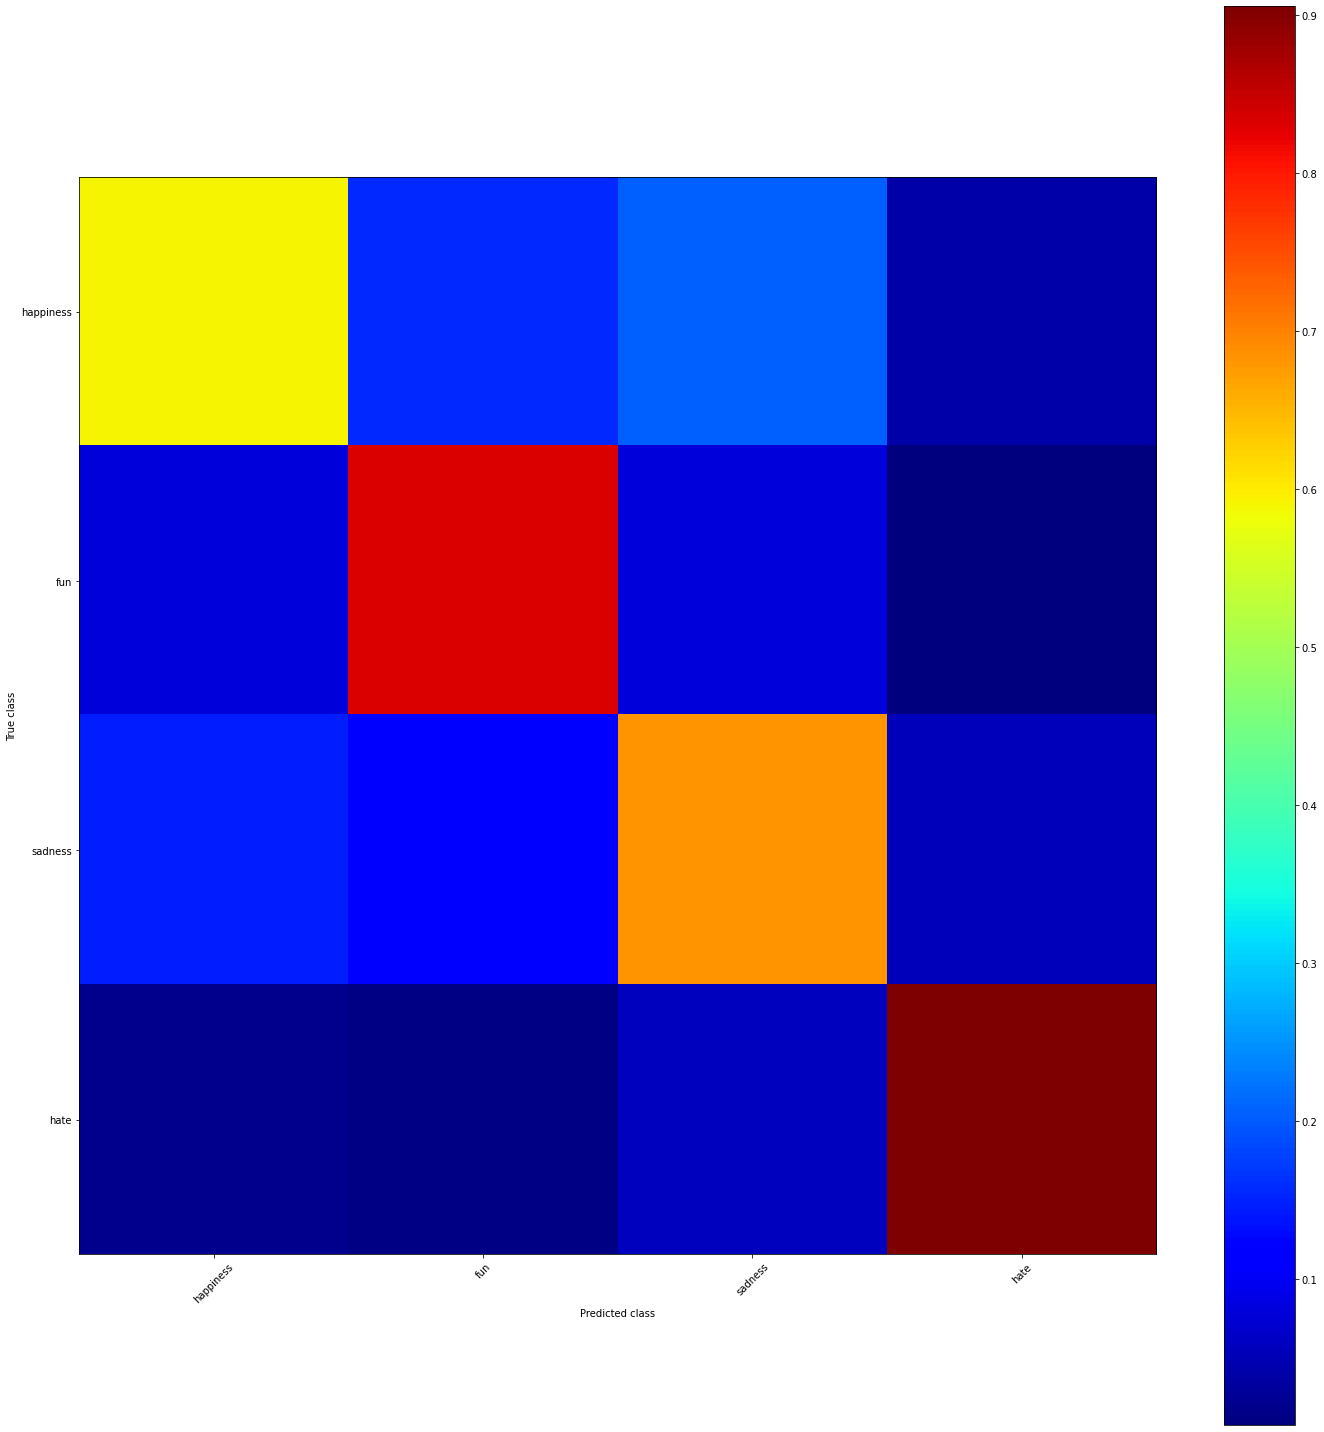

In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(cm, interpolation='nearest', cmap='jet')
plt.colorbar()
ticks = np.arange(len(classes))
plt.xticks(ticks, classes, rotation=45)
plt.yticks(ticks, classes)

plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.tight_layout()

In [ ]:
cm_train = confusion_matrix(y_train_class, y_train_pred_class, normalize='true')
cm_train

array([[0.87688721, 0.03785524, 0.08115009, 0.00410746],
       [0.01427242, 0.97176544, 0.01261764, 0.0013445 ],
       [0.05353546, 0.01918796, 0.91773561, 0.00954097],
       [0.00589818, 0.00434603, 0.02669702, 0.96305877]])

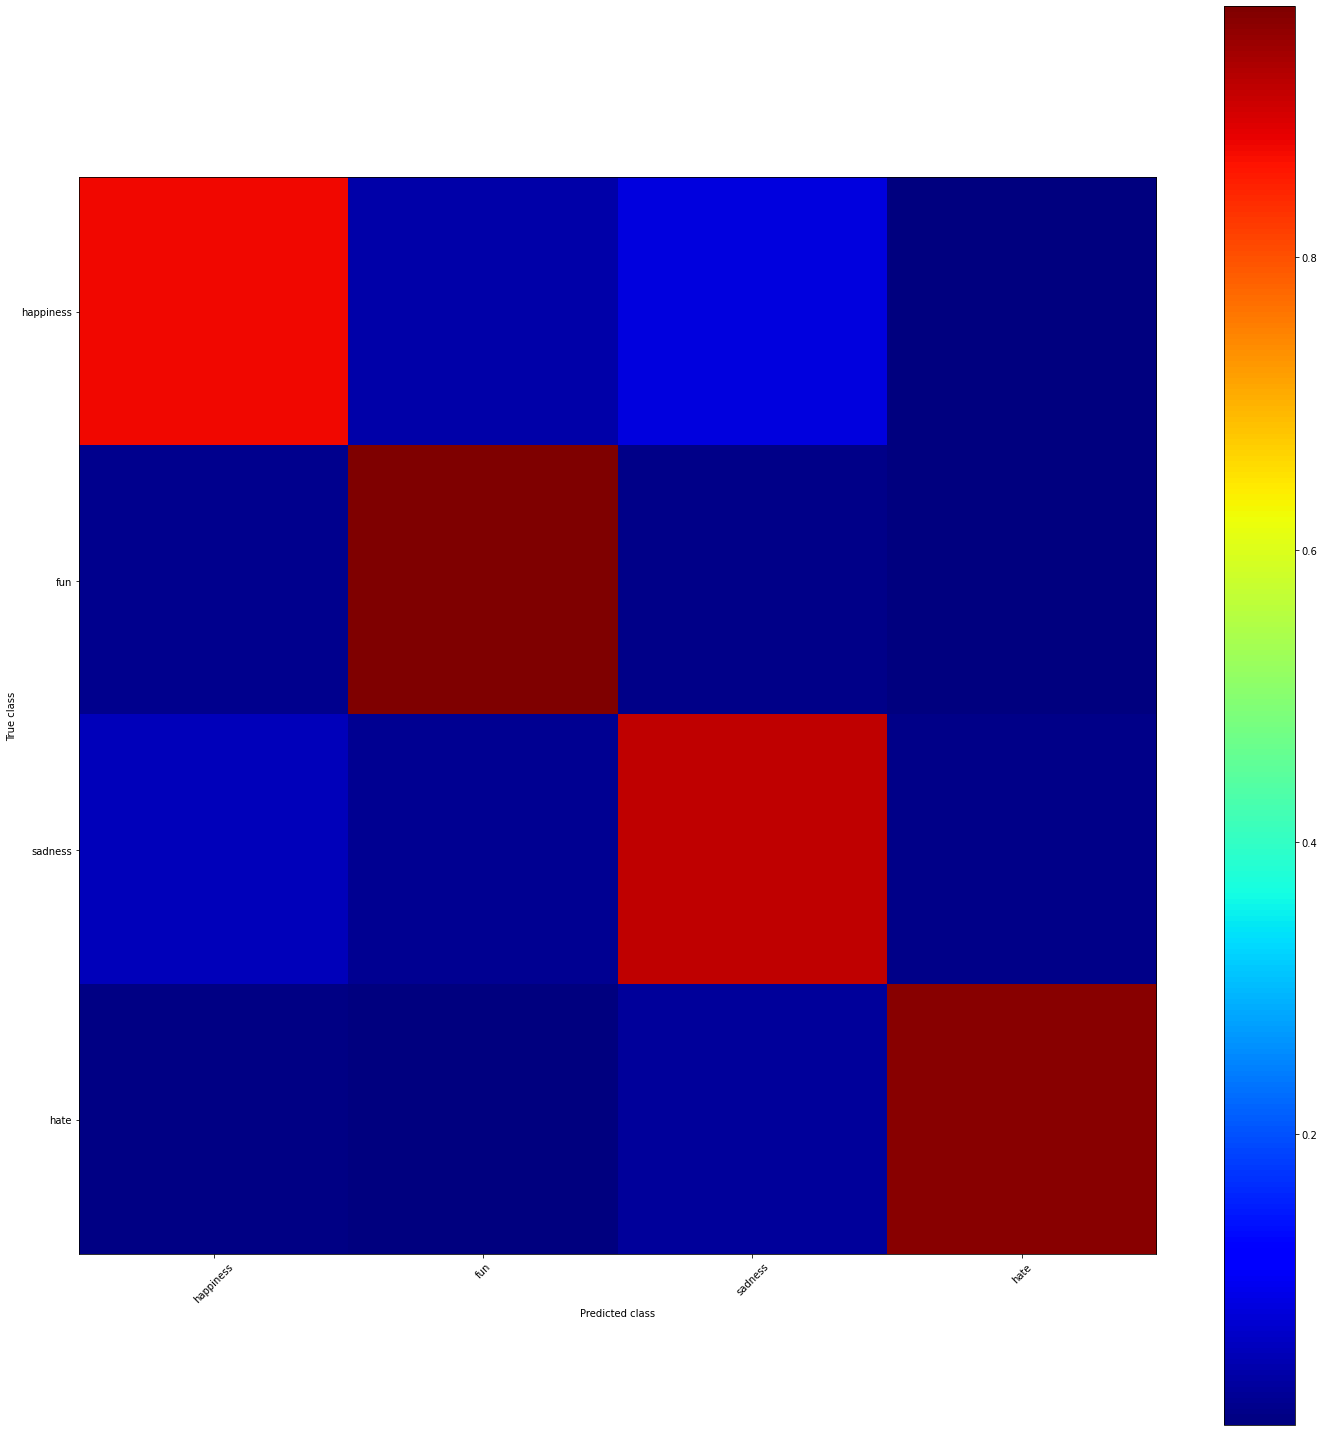

In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(cm_train, interpolation='nearest', cmap='jet')
plt.colorbar()
ticks = np.arange(len(classes))
plt.xticks(ticks, classes, rotation=45)
plt.yticks(ticks, classes)

plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.tight_layout()

### **Test with new sentences**

In [ ]:
seqLen = 15

In [ ]:
def preprocess_user_sentence(sentence, seqLen, eng_contractions, 
                             big_corpus_word_vectors_dict, 
                             word_to_idx_dict, 
                             tokenizer):
    sentence = sentence.lower()
    s = normalize_contractions(sentence, eng_contractions)
    s = simplify_punctuation_and_whitespace(s)
    s = reduce_exaggerations(s)
    tokens = sentence_tokenizer(tk, sentence, big_corpus_word_vectors_dict)
    tokens_in_numbers = [word_to_idx_dict[w] for w in tokens]
    tokens_in_numbers = pad_sequences([tokens_in_numbers], maxlen=seqLen, padding='post')
    
    return tokens_in_numbers

In [ ]:
def create_lstm_model_test():
    input_tensor = Input(shape=(seqLen,), dtype='int32')
    mask = Masking(mask_value=0, input_shape=(seqLen, 50))(input_tensor)
    x = Embedding(vocab_size, 50, input_length=seqLen, trainable=False)(mask)
    x = LSTM(128, return_sequences=True)(x)
    x = LSTM(64, return_sequences=False)(x)
    x = Dense(16, activation='relu')(x)
    output_tensor = Dense(num_classes, activation='softmax')(x)

    model = Model(input_tensor, output_tensor)
    model.compile(optimizer=Adam(learning_rate=3e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()
    return model


In [ ]:
# Load model from checkpoint dir
checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/CS5344/training_1'
latest_cp = tf.train.latest_checkpoint(checkpoint_dir)
# Create a new model instance
trained_model = create_lstm_model_test()

# Load the previously saved weights
trained_model.load_weights(latest_cp)

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 15)]              0         
                                                                 
 masking_13 (Masking)        (None, 15)                0         
                                                                 
 embedding_15 (Embedding)    (None, 15, 50)            972700    
                                                                 
 lstm_26 (LSTM)              (None, 15, 128)           91648     
                                                                 
 lstm_27 (LSTM)              (None, 64)                49408     
                                                                 
 dense_28 (Dense)            (None, 16)                1040      
                                                                 
 dense_29 (Dense)            (None, 4)                 68 

In [ ]:
# Test
sentence = 'I feel bad today. I think I should go to see a doctor. @father'
tk_test = TweetTokenizer()
tokens_in_numbers = preprocess_user_sentence(sentence, seqLen, eng_contractions, big_corpus_word_vectors_dict, vocab_to_int_dict, tk_test)
type_scores = trained_model.predict(tokens_in_numbers).tolist()

# 每个sample sentence会得到四个score，分别对应'happiness', 'fun', 'sadness', 'hate'
print(type_scores)
# 选择取最高的score，如果最高score大于某个阈值（例如0.7），就判断为该类，如果最高的score达不到阈值，判断为没有特殊感情的neutral类

1/1 [==============================] - 1s 839ms/step
[[0.024020923301577568, 0.002253579208627343, 0.9735829830169678, 0.0001425436494173482]]


In [ ]:
lstm_model = load_model('/content/drive/MyDrive/Colab Notebooks/CS5344/lstm_model_v0')

In [ ]:
lstm_model.predict(tokens_in_numbers).tolist()

1/1 [==============================] - 1s 921ms/step


[[0.024020923301577568,
  0.002253579208627343,
  0.9735829830169678,
  0.0001425436494173482]]